In [2]:
import os

import numpy as onp
import jax.numpy as np
import torch
import schnetpack as spk

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

import mlflow
import mlflow.pytorch

mlflow.autolog()

from ..dipole import VectorValuedKRR, train as train_gdml
from utils import matern, coulomb

2021/03/27 19:18:36 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


ValueError: attempted relative import beyond top-level package

In [ ]:
data = np.load('data/HOOH.DFT.PBE-TS.light.MD.500K.50k.R_E_F_D_Q.npz')
X = np.array(data['R'])
y = np.array(data['D'])

In [ ]:
import schnetpack as spk
from ase.db.jsondb import JSONDatabase
from schnetpack.data import AtomsData
atomsdb = AtomsData('data/data.json')
M = len(atomsdb)
print(M)

In [ ]:
# loss function
def squared_norm(batch, result):
    diff = batch['dipole'].squeeze() - result['dipole'].squeeze()
    err_sq = torch.linalg.norm(diff, axis=1)**2
    return err_sq.mean().item()


def train_schnet(train, val, size=50):

    train_loader = spk.AtomsLoader(train, batch_size=2048, shuffle=True)
    val_loader = spk.AtomsLoader(val, batch_size=2048)

    schnet = spk.representation.SchNet(
        n_atom_basis=30, n_filters=30, n_gaussians=20, n_interactions=5,
        cutoff=4., cutoff_network=spk.nn.cutoff.CosineCutoff
    )

    output_alpha = spk.atomistic.DipoleMoment(n_in=30, property='dipole')
    model = spk.AtomisticModel(representation=schnet, output_modules=output_alpha)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    loss = spk.train.build_mse_loss(['dipole'])

    metrics = [spk.metrics.MeanAbsoluteError('dipole')]
    hooks = [
        spk.train.ReduceLROnPlateauHook(
            optimizer,
            patience=5, factor=0.8, min_lr=1e-6,
            stop_after_min=True
        ),
        spk.train.EarlyStoppingHook(8),
        spk.train.CSVHook('schnet_metrics', [])
    ]

    model_dir = f'model-{size}'
    trainer = spk.train.Trainer(
        model_path=model_dir,
        model=model,
        hooks=hooks,
        loss_fn=loss,
        optimizer=optimizer,
        train_loader=train_loader,
        validation_loader=val_loader,
    )

    trainer.train(device='cpu', n_epochs=50)
    best = torch.load(os.path.join(model_dir, 'best_model'))
    mlflow.pytorch.log_model(best, "best")
        
    return best

In [ ]:
data_subset_sizes = list(np.linspace(10, 100, 10, dtype=int))
parameters = {'sigma': loguniform(10**1, 10**4), 'lamb': loguniform(10**-2, 10**3)}

test_indices = onp.random.choice(M, size=100, replace=False)
test_data = atomsdb.create_subset(list(test_indices))
test_batch = list(spk.AtomsLoader(test_data, batch_size=2048))[0]
Xtest, ytest = X[test_indices], y[test_indices]

mask = onp.ones(M, dtype=bool)
mask[test_indices] = False
X, y = X[mask], y[mask]

# train_indices = onp.random.choice(M-100, size=data_subset_sizes[-1], replace=False)
# X, y = X[train_indices], y[train_indices]

errors_gdml, cv_results, errors_schnet = [], [], []
with mlflow.start_run():
    for size in data_subset_sizes:
        with mlflow.start_run(nested=True):
            mlflow.log_param('n_samples', size)
            print(f'size: {size}')
            Xtrain, ytrain = X[:size], y[:size]

            test_error, angle, result = train_gdml(Xtrain, ytrain, Xtest, ytest, cv=RandomizedSearchCV(VectorValuedKRR(), parameters, n_iter=50), return_results=True)
            errors_gdml.append(test_error)
            cv_results.append(result)
            errors_gdml.append(test_error)
            mlflow.log_metric('gdml error', test_error)

            data_cut = atomsdb.create_subset(range(size))
            val_size = size // 10
            train, val, test = spk.train_test_split(
                data=data_cut,
                num_train=size - val_size,
                num_val=val_size
            )
            best_model = train_schnet(train, val, size=size)
            prediction = best_model(test_batch)
            test_error_schnet = squared_norm(prediction, test_batch)
            print(f'schnet error: {test_error_schnet:.6f}')
            mlflow.log_metric('schnet error', test_error_schnet)
            errors_schnet.append(test_error_schnet)


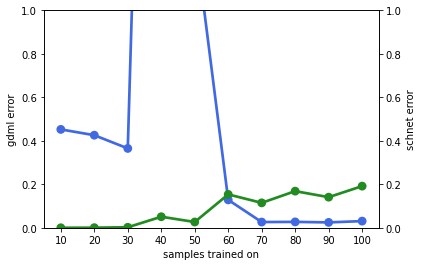

In [35]:
data = pd.DataFrame({'samples trained on': data_subset_sizes, 'gdml error': errors_gdml, 'schnet error': errors_schnet})
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.set_ylim(0, 1)
sns.pointplot(x='samples trained on', y='gdml error', data=data, s=100, ax=ax, color='royalblue')
ax2.set_ylim(ax.get_ylim())
sns.pointplot(x='samples trained on', y='schnet error', data=data, s=100, ax=ax2, color='forestgreen')
plt.savefig('schnet.png')